In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import holidays

from datetime import timedelta
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

## Importação e validação dos dados

In [2]:
df_sales = pd.read_csv("C:\\Users\\User\\Downloads\\Análise Pizzaria\\data\\pizza_sales.csv", sep=";")

# Converter para datetime, tratando múltiplos formatos
df_sales['order_date'] = pd.to_datetime(df_sales['order_date'], format='%d/%m/%Y', errors='coerce').fillna(
             pd.to_datetime(df_sales['order_date'], format='%d-%m-%Y', errors='coerce'))
df_sales['unit_price'] = df_sales['unit_price'].str.replace(',', '.').astype(float)
df_sales['order_time'] = pd.to_datetime(df_sales['order_time'], format='%H:%M:%S').dt.time
df_sales['order_hour'] = pd.to_datetime(df_sales['order_time'], format='%H:%M:%S').dt.hour
df_sales['day_of_week'] = df_sales['order_date'].dt.day_name()
df_sales['pizza_type_id'] = df_sales['pizza_name_id'].str.rsplit('_', n=1).str[0]
df_sales['total_price'] = df_sales['quantity']*df_sales['unit_price']
df_sales.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,pizza_size,order_hour,day_of_week,pizza_type_id,total_price
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,M,11,Thursday,hawaiian,13.25
1,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,M,11,Thursday,classic_dlx,16.00
2,3,2,five_cheese_l,1,2015-01-01,11:57:40,18.50,L,11,Thursday,five_cheese,18.50
3,4,2,ital_supr_l,1,2015-01-01,11:57:40,20.75,L,11,Thursday,ital_supr,20.75
4,5,2,mexicana_m,1,2015-01-01,11:57:40,16.00,M,11,Thursday,mexicana,16.00


In [3]:
df_types = pd.read_csv("C:\\Users\\User\\Downloads\\Análise Pizzaria\\data\\pizza_types.csv", sep=";")
df_types.head()

,pizza_type_id,pizza_name,pizza_category,pizza_ingredients
0,bbq_ckn,The Barbecue Chicken Pizza,Chicken,"Barbecued Chicken, Red Peppers, Green Peppers,..."
1,big_meat,The Big Meat Pizza,Classic,"Bacon, Pepperoni, Italian Sausage, Chorizo Sau..."
2,brie_carre,The Brie Carre Pizza,Supreme,"Brie Carre Cheese, Prosciutto, Caramelized Oni..."
3,calabrese,The Calabrese Pizza,Supreme,"Nduja Salami, Pancetta, Tomatoes, Red Onions, ..."
4,cali_ckn,The California Chicken Pizza,Chicken,"Chicken, Artichoke, Spinach, Garlic, Jalapeno ..."


Utilizando a chave "pizza_type_id", podemos combinar ambas as bases:

In [4]:
# Unir as tabelas para ter os nomes das pizzas e seus ingredientes no dataframe principal
df_pizza = df_sales.merge(df_types, on='pizza_type_id', how='left')
df_pizza = df_pizza.drop(columns=['pizza_id']) # Remover a coluna pizza_id, pois não é necessária e possui a mesma representação que o indíce da base
df_pizza

,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,pizza_size,order_hour,day_of_week,pizza_type_id,total_price,pizza_name,pizza_category,pizza_ingredients
0,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,M,11,Thursday,hawaiian,13.25,The Hawaiian Pizza,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese"
1,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,M,11,Thursday,classic_dlx,16.00,The Classic Deluxe Pizza,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,..."
2,2,five_cheese_l,1,2015-01-01,11:57:40,18.50,L,11,Thursday,five_cheese,18.50,The Five Cheese Pizza,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go..."
3,2,ital_supr_l,1,2015-01-01,11:57:40,20.75,L,11,Thursday,ital_supr,20.75,The Italian Supreme Pizza,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni..."
4,2,mexicana_m,1,2015-01-01,11:57:40,16.00,M,11,Thursday,mexicana,16.00,The Mexicana Pizza,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48615,21348,ckn_alfredo_m,1,2015-12-31,21:23:10,16.75,M,21,Thursday,ckn_alfredo,16.75,The Chicken Alfredo Pizza,Chicken,"Chicken, Red Onions, Red Peppers, Mushrooms, A..."
48616,21348,four_cheese_l,1,2015-12-31,21:23:10,17.95,L,21,Thursday,four_cheese,17.95,The Four Cheese Pizza,Veggie,"Ricotta Cheese, Gorgonzola Piccante Cheese, Mo..."
48617,21348,napolitana_s,1,2015-12-31,21:23:10,12.00,S,21,Thursday,napolitana,12.00,The Napolitana Pizza,Classic,"Tomatoes, Anchovies, Green Olives, Red Onions,..."
48618,21349,mexicana_l,1,2015-12-31,22:09:54,20.25,L,22,Thursday,mexicana,20.25,The Mexicana Pizza,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O..."


In [5]:
df_pizza.shape

(48620, 14)

O conjunto de dados contém informações sobre vendas de pizzas, incluindo detalhes como ID da pizza, ID do pedido, ID do nome da pizza, quantidade, data do pedido, horário do pedido, preço unitário, preço total, tamanho da pizza, categoria da pizza, ingredientes da pizza e nome da pizza. Cada coluna representa um atributo específico relacionado aos dados de vendas de pizza. O conjunto de dados abrange 48.621 pedidos de pizza e transações de clientes, reunindo 12 variáveis relevantes.

In [6]:
df_pizza.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   order_id           48620 non-null  int64         
 1   pizza_name_id      48620 non-null  object        
 2   quantity           48620 non-null  int64         
 3   order_date         48620 non-null  datetime64[ns]
 4   order_time         48620 non-null  object        
 5   unit_price         48620 non-null  float64       
 6   pizza_size         48620 non-null  object        
 7   order_hour         48620 non-null  int32         
 8   day_of_week        48620 non-null  object        
 9   pizza_type_id      48620 non-null  object        
 10  total_price        48620 non-null  float64       
 11  pizza_name         48620 non-null  object        
 12  pizza_category     48620 non-null  object        
 13  pizza_ingredients  48620 non-null  object        
dtypes: dat

In [7]:
df_pizza.describe()

,order_id,quantity,order_date,unit_price,order_hour,total_price
count,48620.000000,48620.000000,48620,48620.000000,48620.000000,48620.000000
mean,10701.479761,1.019622,2015-06-29 11:03:43.611682560,16.494132,15.911806,16.821474
min,1.000000,1.000000,2015-01-01 00:00:00,9.750000,9.000000,9.750000
25%,5337.000000,1.000000,2015-03-31 00:00:00,12.750000,13.000000,12.750000
50%,10682.500000,1.000000,2015-06-28 00:00:00,16.500000,16.000000,16.500000
75%,16100.000000,1.000000,2015-09-28 00:00:00,20.250000,18.000000,20.500000
max,21350.000000,4.000000,2015-12-31 00:00:00,35.950000,23.000000,83.000000
std,6180.119770,0.143077,NaN,3.621789,3.149836,4.437398


In [8]:
df_pizza.isna().sum()

order_id             0
pizza_name_id        0
quantity             0
order_date           0
order_time           0
unit_price           0
pizza_size           0
order_hour           0
day_of_week          0
pizza_type_id        0
total_price          0
pizza_name           0
pizza_category       0
pizza_ingredients    0
dtype: int64

In [9]:
df_pizza.duplicated().sum()

0

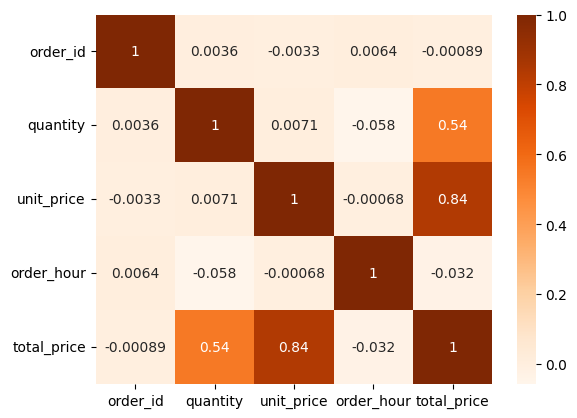

In [10]:
numeric_columns = df_pizza.select_dtypes(include=['number'])
sns.heatmap(numeric_columns.corr(), cmap='Oranges', annot=True)
plt.show()

A baixa correlação de order_hour com outras variáveis (ex.: -0.032 com total_price) indica que o horário do pedido não está diretamente ligado ao valor ou volume do pedido. Além disso, como esperado, order_id funciona como identificador único e não carrega relação direta com outras variáveis quantitativas, estando ali apenas para estruturação do dado.

C:\Users\User\AppData\Local\Temp\ipykernel_21084\521543941.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


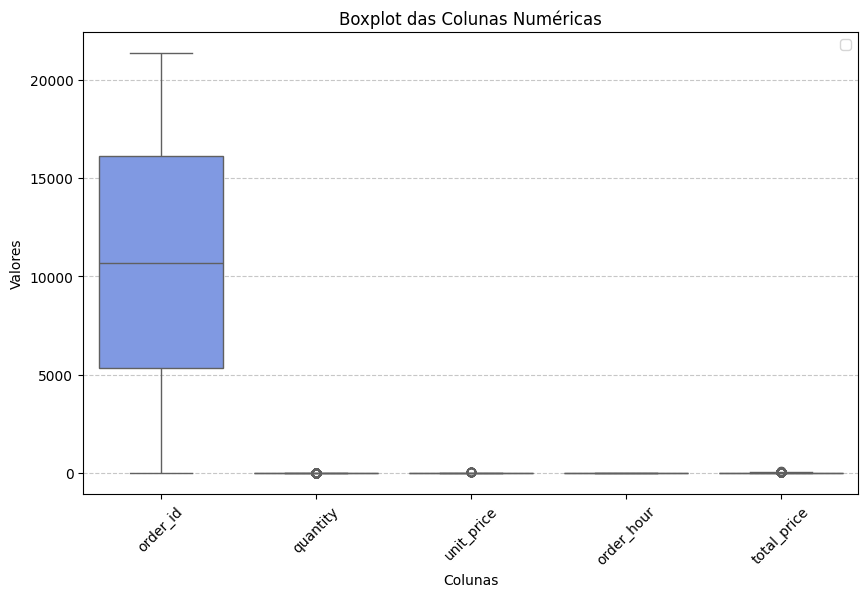

In [11]:
numeric_data = df_pizza.select_dtypes(include='number')

# Criar o boxplot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=numeric_data, palette="coolwarm")

# Ajustar rótulos e título
plt.xticks(rotation=45)
plt.title('Boxplot das Colunas Numéricas')
plt.xlabel('Colunas')
plt.ylabel('Valores')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()


In [12]:
# Calcular IQR (Interquartile Range)
Q1 = df_pizza['total_price'].quantile(0.25)
Q3 = df_pizza['total_price'].quantile(0.75)
IQR = Q3 - Q1

# Definir limites para detectar outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar outliers
outliers = df_pizza[(df_pizza['total_price'] < lower_bound) | (df_pizza['total_price'] > upper_bound)]

# Exibir resumo dos outliers
print(f"Outliers detectados: {len(outliers)}")
print(f"Faixa normal: {lower_bound:.2f} a {upper_bound:.2f}")
print(f"Estatísticas dos outliers:\n{outliers.describe()}")

# Exibir todos os outliers
outliers

Outliers detectados: 613
Faixa normal: 1.12 a 32.12
Estatísticas dos outliers:
           order_id    quantity                     order_date  unit_price  \
count    613.000000  613.000000                            613  613.000000   
mean   10786.477977    1.998369  2015-07-01 01:29:15.954322944   19.784584   
min       78.000000    1.000000            2015-01-02 00:00:00   12.000000   
25%     5820.000000    2.000000            2015-04-08 00:00:00   16.750000   
50%    10555.000000    2.000000            2015-06-26 00:00:00   20.250000   
75%    16330.000000    2.000000            2015-10-02 00:00:00   20.750000   
max    21343.000000    4.000000            2015-12-31 00:00:00   35.950000   
std     6098.924533    0.315706                            NaN    4.144206   

       order_hour  total_price  
count  613.000000   613.000000  
mean    14.675367    38.624878  
min     10.000000    32.500000  
25%     12.000000    33.500000  
50%     13.000000    40.500000  
75%     17.000000   

,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,pizza_size,order_hour,day_of_week,pizza_type_id,total_price,pizza_name,pizza_category,pizza_ingredients
183,78,spicy_ital_l,3,2015-01-02,12:28:14,20.75,L,12,Friday,spicy_ital,62.25,The Spicy Italian Pizza,Supreme,"Capocollo, Tomatoes, Goat Cheese, Artichokes, ..."
211,91,bbq_ckn_l,2,2015-01-02,15:14:43,20.75,L,15,Friday,bbq_ckn,41.50,The Barbecue Chicken Pizza,Chicken,"Barbecued Chicken, Red Peppers, Green Peppers,..."
341,144,bbq_ckn_m,3,2015-01-03,13:44:28,16.75,M,13,Saturday,bbq_ckn,50.25,The Barbecue Chicken Pizza,Chicken,"Barbecued Chicken, Red Peppers, Green Peppers,..."
456,193,ckn_alfredo_l,2,2015-01-03,20:55:47,20.75,L,20,Saturday,ckn_alfredo,41.50,The Chicken Alfredo Pizza,Chicken,"Chicken, Red Onions, Red Peppers, Mushrooms, A..."
611,271,cali_ckn_m,2,2015-01-05,14:22:19,16.75,M,14,Monday,cali_ckn,33.50,The California Chicken Pizza,Chicken,"Chicken, Artichoke, Spinach, Garlic, Jalapeno ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48396,21251,four_cheese_l,2,2015-12-30,12:45:20,17.95,L,12,Wednesday,four_cheese,35.90,The Four Cheese Pizza,Veggie,"Ricotta Cheese, Gorgonzola Piccante Cheese, Mo..."
48417,21260,prsc_argla_m,2,2015-12-30,15:45:32,16.50,M,15,Wednesday,prsc_argla,33.00,The Prosciutto and Arugula Pizza,Supreme,"Prosciutto di San Daniele, Arugula, Mozzarella..."
48466,21288,classic_dlx_m,3,2015-12-31,13:04:18,16.00,M,13,Thursday,classic_dlx,48.00,The Classic Deluxe Pizza,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,..."
48575,21331,bbq_ckn_l,2,2015-12-31,19:05:04,20.75,L,19,Thursday,bbq_ckn,41.50,The Barbecue Chicken Pizza,Chicken,"Barbecued Chicken, Red Peppers, Green Peppers,..."


Apesar de termos identificado outliers com o método interquartil, vamos mantê-los na base, pois eles representam pedidos reais e importantes para nossa análise.

## Análise Exploratória dos Dados

Vamos iniciar a etapa de análise exploratória dos dados, com o intuito de conhecer melhor os valores que existem na base.

### Análise de Vendas e Receita

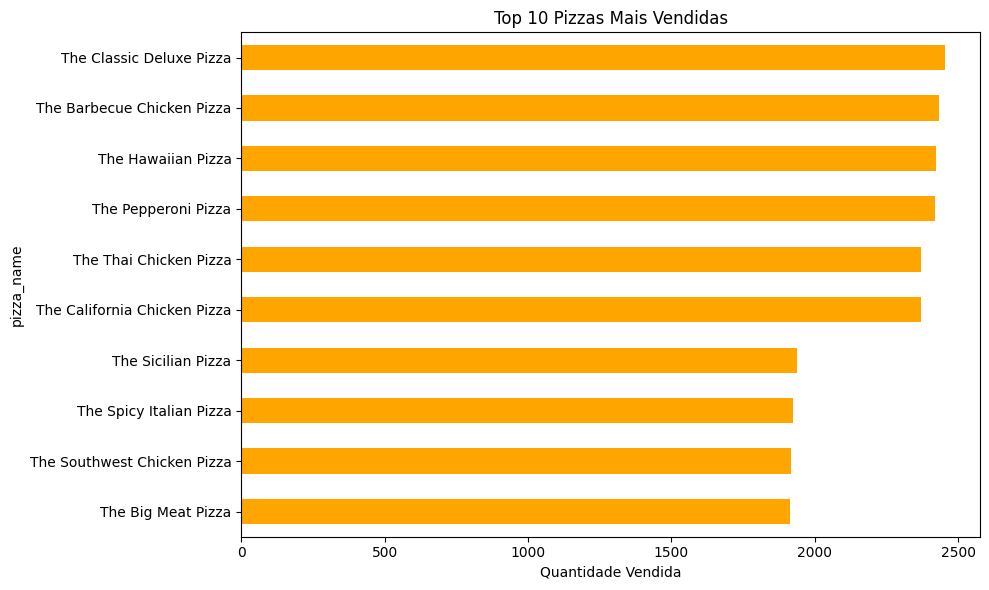

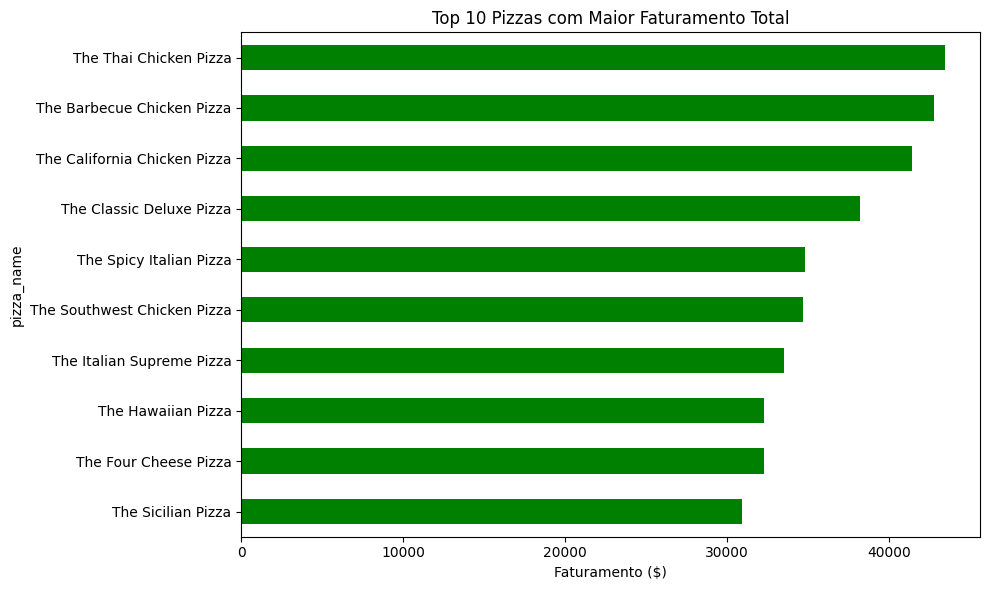

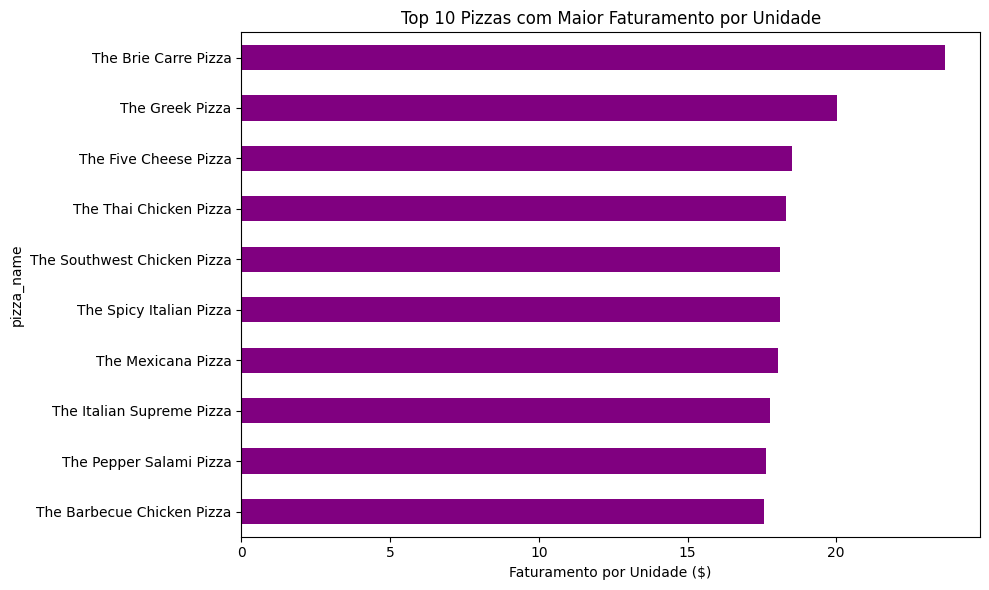

In [13]:
# Pizzas mais vendidas
top_pizzas = df_pizza.groupby('pizza_name')['quantity'].sum().sort_values(ascending=False)
revenue_per_pizza = df_pizza.groupby('pizza_name')['total_price'].sum().sort_values(ascending=False)
revenue_per_unit = revenue_per_pizza / top_pizzas
revenue_per_unit = revenue_per_unit.sort_values(ascending=False)

# 1. Pizzas mais vendidas
plt.figure(figsize=(10, 6))
top_pizzas.head(10).plot(kind='barh', color='orange')
plt.title('Top 10 Pizzas Mais Vendidas')
plt.xlabel('Quantidade Vendida')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 2. Total faturado por pizza
plt.figure(figsize=(10, 6))
revenue_per_pizza.head(10).plot(kind='barh', color='green')
plt.title('Top 10 Pizzas com Maior Faturamento Total')
plt.xlabel('Faturamento ($)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 3. Faturamento por unidade vendida
plt.figure(figsize=(10, 6))
revenue_per_unit.head(10).plot(kind='barh', color='purple')
plt.title('Top 10 Pizzas com Maior Faturamento por Unidade')
plt.xlabel('Faturamento por Unidade ($)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

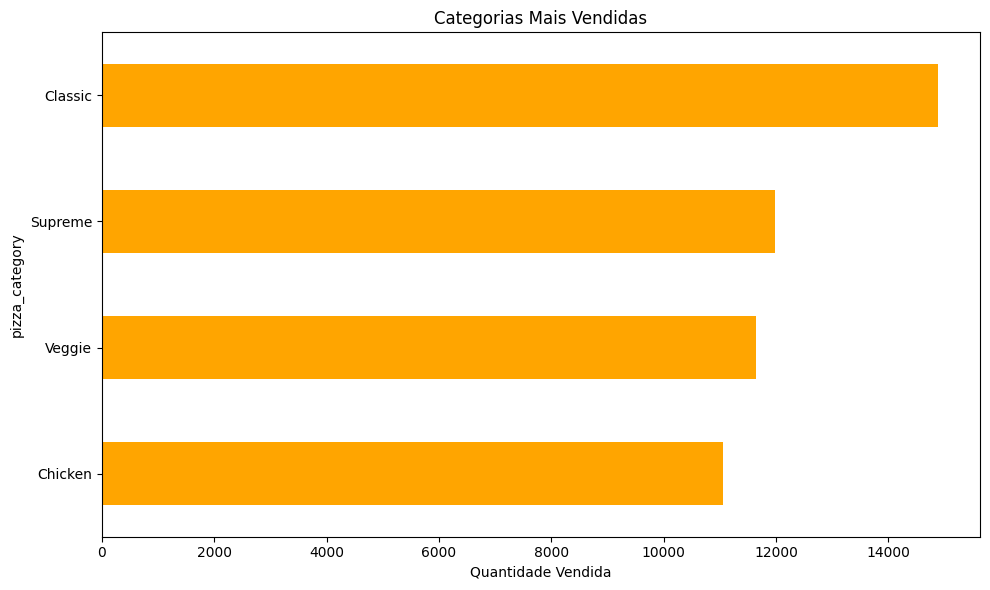

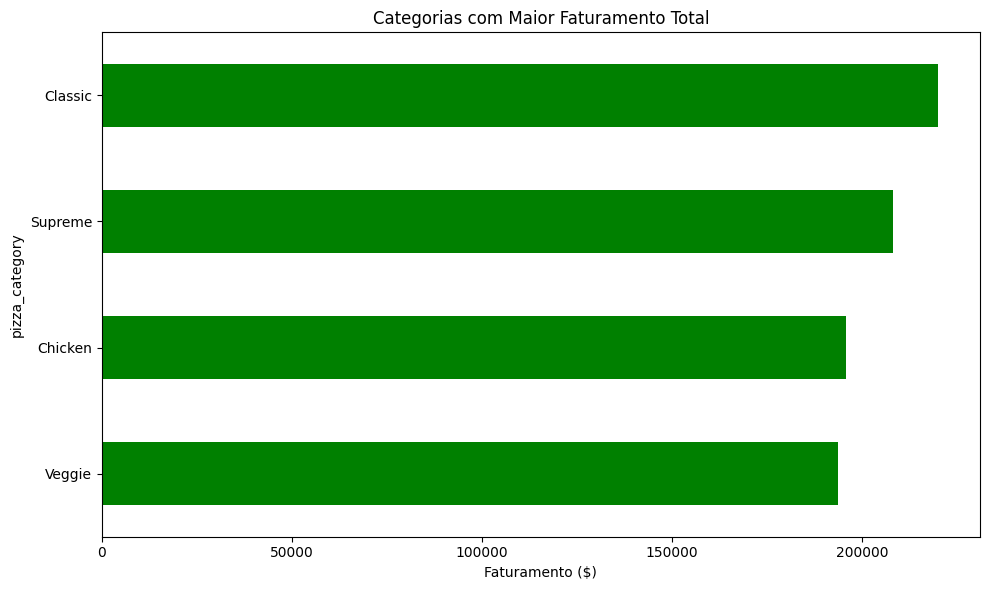

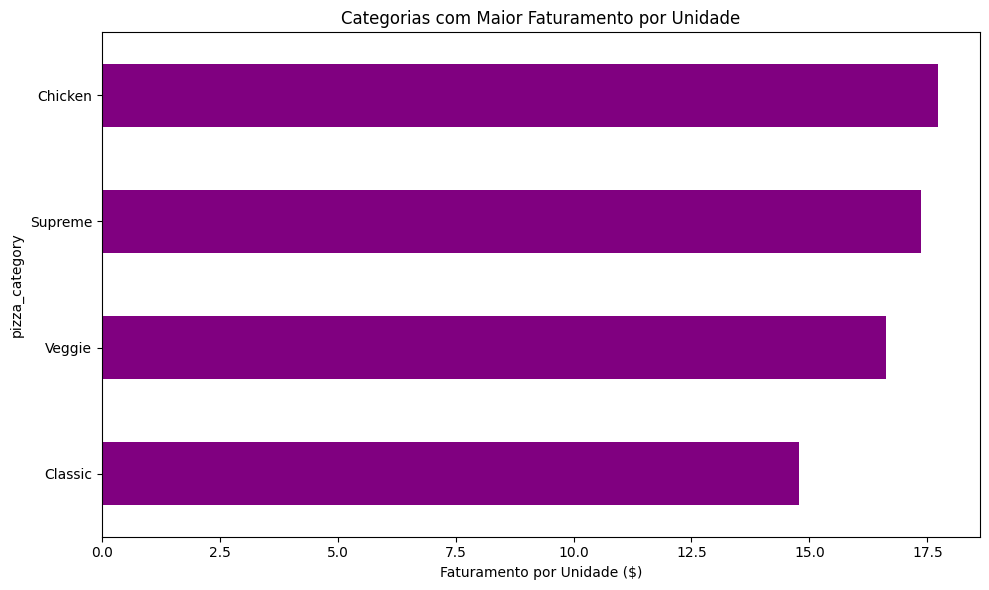

In [14]:
# Pizzas mais vendidas
top_pizzas_category = df_pizza.groupby('pizza_category')['quantity'].sum().sort_values(ascending=False)
revenue_per_pizza_category = df_pizza.groupby('pizza_category')['total_price'].sum().sort_values(ascending=False)
revenue_per_unit_category = revenue_per_pizza_category / top_pizzas_category
revenue_per_unit_category = revenue_per_unit_category.sort_values(ascending=False)

# 1. Pizzas mais vendidas
plt.figure(figsize=(10, 6))
top_pizzas_category.plot(kind='barh', color='orange')
plt.title('Categorias Mais Vendidas')
plt.xlabel('Quantidade Vendida')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 2. Total faturado por pizza
plt.figure(figsize=(10, 6))
revenue_per_pizza_category.plot(kind='barh', color='green')
plt.title('Categorias com Maior Faturamento Total')
plt.xlabel('Faturamento ($)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 3. Faturamento por unidade vendida
plt.figure(figsize=(10, 6))
revenue_per_unit_category.head(10).plot(kind='barh', color='purple')
plt.title('Categorias com Maior Faturamento por Unidade')
plt.xlabel('Faturamento por Unidade ($)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [15]:
# Ticket médio, mediana e moda por pedido
ticket_medio = df_pizza.groupby('order_id')['total_price'].sum().mean()
median = df_pizza.groupby('order_id')['total_price'].sum().median()
mode_series = df_pizza.groupby('order_id')['total_price'].sum().mode()

print(f'Ticket médio por pedido: ${ticket_medio:.2f}')
print(f'Mediana por pedido: ${median:.2f}')

# Verifica se há uma ou mais modas
if len(mode_series) == 1:
    print(f'Moda por pedido: ${mode_series.iloc[0]:.2f}')
else:
    moda_formatada = ', '.join(f"${m:.2f}" for m in mode_series)
    print(f'Modas por pedido: {moda_formatada}')

Ticket médio por pedido: $38.31
Mediana por pedido: $32.50
Moda por pedido: $20.75


Vamos fazer uma análise dos ingredientes utilizados nas pizzas:

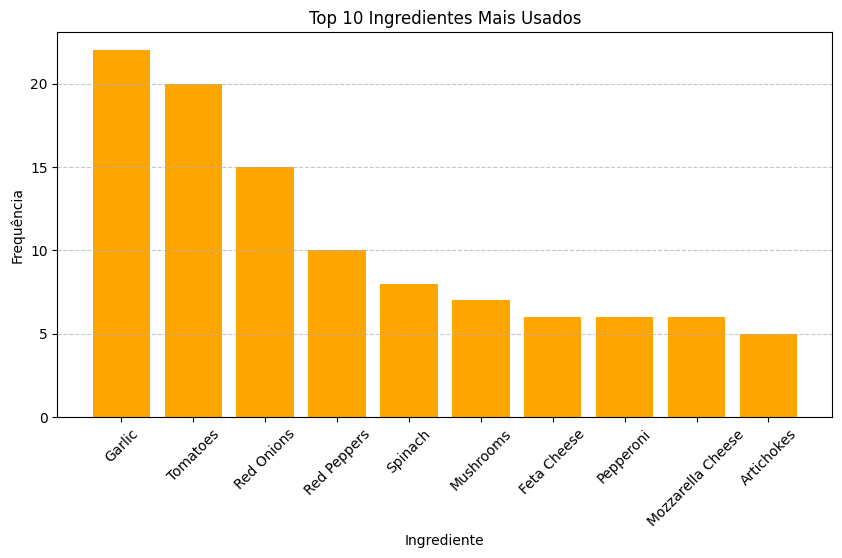

In [16]:
# Separar os ingredientes em listas
split_ingredients = df_types['pizza_ingredients'].str.split(', ')

# Achatar a lista e contar a frequência de cada ingrediente
all_ingredients = [ingredient for sublist in split_ingredients for ingredient in sublist]
ingredient_counts = pd.Series(all_ingredients).value_counts()

# Pegar os 10 ingredientes mais comuns
top_ingredients = ingredient_counts.head(10)

# Criar o gráfico de barras com Matplotlib
plt.figure(figsize=(10, 5))
plt.bar(top_ingredients.index, top_ingredients.values, color='orange')
plt.xlabel('Ingrediente')
plt.ylabel('Frequência')
plt.title('Top 10 Ingredientes Mais Usados')
plt.xticks(rotation=45)  # Rotacionar os rótulos para melhor leitura
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Adicionar grade para facilitar a leitura

# Mostrar o gráfico
plt.show()


Com isso, vamos definir custos unitários para os ingredientes das pizzas. Para isso, será criada uma base sintética com base na sofisticação do ingrediente, obtendo assim um valor aproximado para o custo das pizzas.

In [17]:
# Categorias com faixas de preços definidas
categorias_precos = {
    "vegetais_comuns": (1.00, 2.50),
    "queijos_especiais": (3.00, 6.00),
    "carnes_premium": (5.00, 10.00),
    "molhos_especiais": (2.00, 5.00),
    "frutos_do_mar": (2.50, 5.00),
    "gourmet_ervas": (2.00, 4.00)
}

# Mapeamento dos ingredientes para suas categorias
categoria_ingredientes = {
    # Vegetais comuns
    "Red Peppers": "vegetais_comuns", "Green Peppers": "vegetais_comuns", "Tomatoes": "vegetais_comuns",
    "Red Onions": "vegetais_comuns", "Garlic": "vegetais_comuns", "Spinach": "vegetais_comuns",
    "Mushrooms": "vegetais_comuns", "Zucchini": "vegetais_comuns", "Corn": "vegetais_comuns",
    "Green Olives": "vegetais_comuns", "Onions": "vegetais_comuns", "Eggplant": "vegetais_comuns",
    "Plum Tomatoes": "vegetais_comuns", "Cilantro": "vegetais_comuns", "Oregano": "gourmet_ervas",
    
    # Queijos especiais
    "Brie Carre Cheese": "queijos_especiais", "Fontina Cheese": "queijos_especiais", "Gouda Cheese": "queijos_especiais",
    "Asiago Cheese": "queijos_especiais", "Mozzarella Cheese": "queijos_especiais", "Provolone Cheese": "queijos_especiais",
    "Smoked Gouda Cheese": "queijos_especiais", "Romano Cheese": "queijos_especiais", "Blue Cheese": "queijos_especiais",
    "Ricotta Cheese": "queijos_especiais", "Gorgonzola Piccante Cheese": "queijos_especiais",
    "Parmigiano Reggiano Cheese": "queijos_especiais", "Feta Cheese": "queijos_especiais",
    "Goat Cheese": "queijos_especiais",
    
    # Carnes premium
    "Barbecued Chicken": "carnes_premium", "Chicken": "carnes_premium", "Bacon": "carnes_premium",
    "Pepperoni": "carnes_premium", "Italian Sausage": "carnes_premium", "Chorizo Sausage": "carnes_premium",
    "Prosciutto": "carnes_premium", "Nduja Salami": "carnes_premium", "Pancetta": "carnes_premium",
    "Sliced Ham": "carnes_premium", "Capocollo": "carnes_premium", "Calabrese Salami": "carnes_premium",
    "Genoa Salami": "carnes_premium", "Prosciutto di San Daniele": "carnes_premium",
    "Coarse Sicilian Salami": "carnes_premium", "Luganega Sausage": "carnes_premium",
    "Soppressata Salami": "carnes_premium", "Beef Chuck Roast": "carnes_premium",
    
    # Molhos especiais
    "Barbecue Sauce": "molhos_especiais", "Alfredo Sauce": "molhos_especiais", "Pesto Sauce": "molhos_especiais",
    "Chipotle Sauce": "molhos_especiais", "Thai Sweet Chilli Sauce": "molhos_especiais",
    
    # Frutos do mar
    "Anchovies": "frutos_do_mar",
    
    # Gourmet e ervas
    "Caramelized Onions": "gourmet_ervas", "Pears": "gourmet_ervas", "Thyme": "gourmet_ervas",
    "Arugula": "gourmet_ervas", "Peperoncini verdi": "gourmet_ervas", "Sun-dried Tomatoes": "gourmet_ervas",
    "Artichoke": "gourmet_ervas", "Artichokes": "gourmet_ervas", "Kalamata Olives": "gourmet_ervas"
}

# Obter lista única de ingredientes fornecida anteriormente
ingredientes_unicos = list(set([
    'Barbecued Chicken', 'Red Peppers', 'Green Peppers', 'Tomatoes', 'Red Onions', 'Barbecue Sauce',
    'Bacon', 'Pepperoni', 'Italian Sausage', 'Chorizo Sausage', 'Brie Carre Cheese', 'Prosciutto',
    'Caramelized Onions', 'Pears', 'Thyme', 'Garlic', 'Nduja Salami', 'Pancetta', 'Friggitello Peppers',
    'Chicken', 'Artichoke', 'Spinach', 'Jalapeno Peppers', 'Fontina Cheese', 'Gouda Cheese',
    'Mushrooms', 'Asiago Cheese', 'Alfredo Sauce', 'Pesto Sauce', 'Mozzarella Cheese', 'Provolone Cheese',
    'Smoked Gouda Cheese', 'Romano Cheese', 'Blue Cheese', 'Ricotta Cheese', 'Gorgonzola Piccante Cheese',
    'Parmigiano Reggiano Cheese', 'Green Olives', 'Feta Cheese', 'Sliced Ham', 'Pineapple', 'Capocollo',
    'Goat Cheese', 'Oregano', 'Calabrese Salami', 'Eggplant', 'Kalamata Olives', 'Sun-dried Tomatoes',
    'Plum Tomatoes', 'Cilantro', 'Corn', 'Chipotle Sauce', 'Anchovies', 'Genoa Salami',
    'Prosciutto di San Daniele', 'Arugula', 'Coarse Sicilian Salami', 'Luganega Sausage', 'Onions',
    'Soppressata Salami', 'Beef Chuck Roast', 'Thai Sweet Chilli Sauce', 'Zucchini', 'Peperoncini verdi'
]))

# Gerar os preços coerentes
np.random.seed(42)
custos = []
for ing in ingredientes_unicos:
    categoria = categoria_ingredientes.get(ing, "vegetais_comuns")
    faixa = categorias_precos[categoria]
    custo = np.round(np.random.uniform(faixa[0], faixa[1]), 2)
    custos.append((ing, custo, categoria))

# Criar DataFrame final
df_precos_coerentes = pd.DataFrame(custos, columns=["Ingrediente", "Custo_Unitario_USD", "Categoria"])

df_precos_coerentes.sort_values(by="Custo_Unitario_USD", ascending=False).head(10)

,Ingrediente,Custo_Unitario_USD,Categoria
50,Calabrese Salami,9.85,carnes_premium
34,Genoa Salami,9.83,carnes_premium
7,Beef Chuck Roast,9.33,carnes_premium
62,Italian Sausage,9.14,carnes_premium
25,Pancetta,8.93,carnes_premium
2,Soppressata Salami,8.66,carnes_premium
8,Prosciutto,8.01,carnes_premium
17,Chicken,7.62,carnes_premium
27,Pepperoni,7.57,carnes_premium
39,Coarse Sicilian Salami,7.20,carnes_premium


Com isso, temos o custo unitário dos ingredientes usados nas pizzas.

In [18]:
ingredient_costs = df_precos_coerentes.set_index('Ingrediente')['Custo_Unitario_USD'].to_dict()

def calcular_custo(ingredientes_str):
    ingredientes = [ing.strip() for ing in ingredientes_str.split(',')]
    return sum(ingredient_costs.get(ing, 0) for ing in ingredientes)

# Aplicar a função ao dataframe
df_pizza['custo_total_ingredientes'] = df_pizza['pizza_ingredients'].apply(calcular_custo)

Agora, temos o custo total dos ingredientes por pizzas. Para melhorar o realismo da análise, vamos levar em consideração um fator de tamanho, que impactará o custo:

In [19]:
# Criar o dicionário com os pesos por tamanho
fatores_tamanho = {
    'S': 0.50,
    'M': 0.75,
    'L': 1.00,
    'XL': 1.25,
    'XXL': 1.50
}

df_pizza['fator_tamanho'] = df_pizza['pizza_size'].map(fatores_tamanho)
df_pizza['custo_total_ingredientes_ajustado'] = df_pizza['custo_total_ingredientes'] * df_pizza['fator_tamanho']
df_pizza['custo_total_ingredientes_ajustado'] = df_pizza['custo_total_ingredientes_ajustado'].round(2)

Por fim, vamos adicionar um custo adicional por pizza, referente a pontos que não são ingredientes, mas que são utilizados em toda a pizza, como massa, embalagem e mão de obra:

In [20]:
custos_adicionais = {
    'S': 0.50,
    'M': 1.00,
    'L': 1.50,
    'XL': 2.00,
    'XXL': 2.50
}

# Mapear o custo adicional por tamanho
df_pizza['custo_extra'] = df_pizza['pizza_size'].map(custos_adicionais)

# Cálculo final do custo total (ingredientes ajustados + adicionais)
df_pizza['custo_total_final'] = df_pizza['custo_total_ingredientes_ajustado'] + df_pizza['custo_extra']
df_pizza['custo_total_final'] = df_pizza['custo_total_final'].round(2)

Com essas informações, vamos calcular o lucro por pizza e sua margem percentual:

In [21]:
# Margem em valor monetário
df_pizza['lucro_unitario'] = df_pizza['unit_price'] - df_pizza['custo_total_final']

# Margem percentual
df_pizza['margem_percentual'] = (df_pizza['lucro_unitario'] / df_pizza['unit_price']) * 100
df_pizza

,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,pizza_size,order_hour,day_of_week,pizza_type_id,...,pizza_name,pizza_category,pizza_ingredients,custo_total_ingredientes,fator_tamanho,custo_total_ingredientes_ajustado,custo_extra,custo_total_final,lucro_unitario,margem_percentual
0,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,M,11,Thursday,hawaiian,...,The Hawaiian Pizza,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",14.56,0.75,10.92,1.0,11.92,1.33,10.037736
1,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,M,11,Thursday,classic_dlx,...,The Classic Deluxe Pizza,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",16.60,0.75,12.45,1.0,13.45,2.55,15.937500
2,2,five_cheese_l,1,2015-01-01,11:57:40,18.50,L,11,Thursday,five_cheese,...,The Five Cheese Pizza,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",24.29,1.00,24.29,1.5,25.79,-7.29,-39.405405
3,2,ital_supr_l,1,2015-01-01,11:57:40,20.75,L,11,Thursday,ital_supr,...,The Italian Supreme Pizza,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",20.96,1.00,20.96,1.5,22.46,-1.71,-8.240964
4,2,mexicana_m,1,2015-01-01,11:57:40,16.00,M,11,Thursday,mexicana,...,The Mexicana Pizza,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",14.43,0.75,10.82,1.0,11.82,4.18,26.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48615,21348,ckn_alfredo_m,1,2015-12-31,21:23:10,16.75,M,21,Thursday,ckn_alfredo,...,The Chicken Alfredo Pizza,Chicken,"Chicken, Red Onions, Red Peppers, Mushrooms, A...",18.84,0.75,14.13,1.0,15.13,1.62,9.671642
48616,21348,four_cheese_l,1,2015-12-31,21:23:10,17.95,L,21,Thursday,four_cheese,...,The Four Cheese Pizza,Veggie,"Ricotta Cheese, Gorgonzola Piccante Cheese, Mo...",22.37,1.00,22.37,1.5,23.87,-5.92,-32.980501
48617,21348,napolitana_s,1,2015-12-31,21:23:10,12.00,S,21,Thursday,napolitana,...,The Napolitana Pizza,Classic,"Tomatoes, Anchovies, Green Olives, Red Onions,...",9.11,0.50,4.56,0.5,5.06,6.94,57.833333
48618,21349,mexicana_l,1,2015-12-31,22:09:54,20.25,L,22,Thursday,mexicana,...,The Mexicana Pizza,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",14.43,1.00,14.43,1.5,15.93,4.32,21.333333


In [22]:
resumo_rentabilidade = df_pizza.groupby(['pizza_name', 'pizza_size']).agg(
    vendas=('quantity', 'sum'),
    preco_medio=('unit_price', 'mean'),
    custo_medio=('custo_total_final', 'mean'),
    lucro_medio=('lucro_unitario', 'mean'),
    margem_media_percentual=('margem_percentual', 'mean')
).reset_index()

# Ordenar pelas mais rentáveis
mais_rentaveis = resumo_rentabilidade.sort_values(by='margem_media_percentual', ascending=False).reset_index(drop=True)
mais_rentaveis

,pizza_name,pizza_size,vendas,preco_medio,custo_medio,lucro_medio,margem_media_percentual
0,The Napolitana Pizza,S,471,12.00,5.06,6.94,57.833333
1,The Italian Vegetables Pizza,S,305,12.75,5.96,6.79,53.254902
2,The Spinach and Feta Pizza,S,439,12.00,5.74,6.26,52.166667
3,The Green Garden Pizza,S,600,12.00,5.75,6.25,52.083333
4,The Spinach Pesto Pizza,S,404,12.50,6.08,6.42,51.360000
...,...,...,...,...,...,...,...
86,The Pepper Salami Pizza,S,322,12.50,16.08,-3.58,-28.640000
87,The Four Cheese Pizza,L,1316,17.95,23.87,-5.92,-32.980501
88,The Five Cheese Pizza,L,1409,18.50,25.79,-7.29,-39.405405
89,The Pepper Salami Pizza,M,428,16.50,24.38,-7.88,-47.757576


Com isso, vemos que há pizzas que trazem uma boa margem de lucro, como a "The Brie Carre Pizza" e "The Spinach and Feta Pizza", ambas de tamanho S, mas há pizzas em que o custo de produção é maior que o preço de venda da pizza, como a "The Pepper Salami Pizza", de tamanho M e L, e a "The Five Cheese Pizza", de tamanho L. Para esses casos, pode ser adotado um novo preço de venda para a pizza, ou até mesmo a remoção do item do cardápio.

In [23]:
mais_rentaveis.loc[mais_rentaveis['pizza_name'] == 'The Southwest Chicken Pizza'].sort_values(by='margem_media_percentual', ascending=False)

,pizza_name,pizza_size,vendas,preco_medio,custo_medio,lucro_medio,margem_media_percentual
44,The Southwest Chicken Pizza,S,367,12.75,10.57,2.18,17.098039
63,The Southwest Chicken Pizza,M,534,16.75,16.11,0.64,3.820896
71,The Southwest Chicken Pizza,L,1016,20.75,21.65,-0.90,-4.337349


Há casos como a pizza "The Southwest Chicken Pizza", em que um tamanho S traz uma margem de lucro positiva, enquanto os tamanhos maiores não apresentam o mesmo comportamento. Para casos similares, pode-se vender apenas pizzas de tamanho S, para que não haja perdas de lucro com a venda.

In [35]:
resumo_rentabilidade = df_pizza.groupby(['pizza_size']).agg(
    margem_media_percentual=('margem_percentual', 'mean')
).reset_index()

# Ordenar pelas mais rentáveis
mais_rentaveis = resumo_rentabilidade.sort_values(by='margem_media_percentual', ascending=False).reset_index(drop=True)
mais_rentaveis

,pizza_size,margem_media_percentual
0,S,23.149563
1,M,13.718861
2,XXL,2.420028
3,L,0.914526
4,XL,-14.313725


Verificando a rentabilidade por tamanho, verificamos que as pizzas menores, S e M, possuem uma margem de lucro maior que os demais tamanhos, então são tamanhos que devem ser priorizados em campanhas e promoções realizadas.

### Análise por tamanho das pizzas

In [24]:
# Total de pizzas vendidas por tamanho
sales_by_size = df_pizza.groupby('pizza_size')['quantity'].sum().sort_values(ascending=False)

# Receita total por tamanho
revenue_by_size = df_pizza.groupby('pizza_size')['total_price'].sum().sort_values(ascending=False)

# Preço médio por tamanho
avg_price_by_size = df_pizza.groupby('pizza_size')['unit_price'].mean()

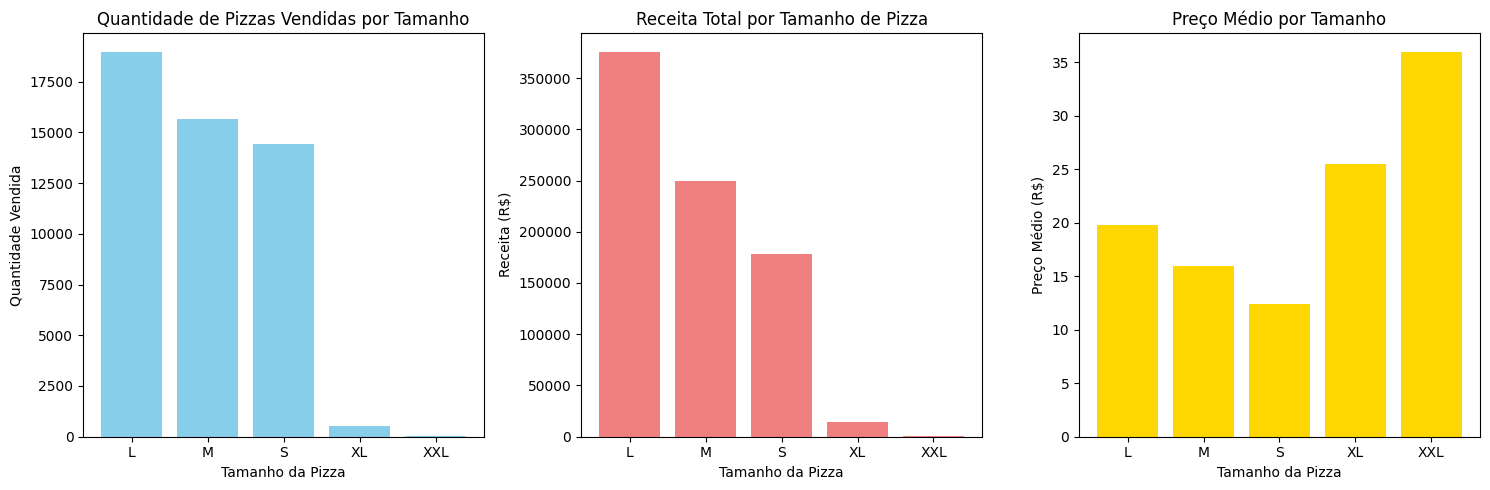

In [25]:
# Visualizar os resultados
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Gráfico de pizzas mais vendidas por tamanho
axes[0].bar(sales_by_size.index, sales_by_size.values, color='skyblue')
axes[0].set_title("Quantidade de Pizzas Vendidas por Tamanho")
axes[0].set_xlabel("Tamanho da Pizza")
axes[0].set_ylabel("Quantidade Vendida")

# Gráfico de receita por tamanho
axes[1].bar(revenue_by_size.index, revenue_by_size.values, color='lightcoral')
axes[1].set_title("Receita Total por Tamanho de Pizza")
axes[1].set_xlabel("Tamanho da Pizza")
axes[1].set_ylabel("Receita (R$)")

# Gráfico de preço médio por tamanho
axes[2].bar(avg_price_by_size.index, avg_price_by_size.values, color='gold')
axes[2].set_title("Preço Médio por Tamanho")
axes[2].set_xlabel("Tamanho da Pizza")
axes[2].set_ylabel("Preço Médio (R$)")

plt.tight_layout()
plt.show()

### Análise Temporal

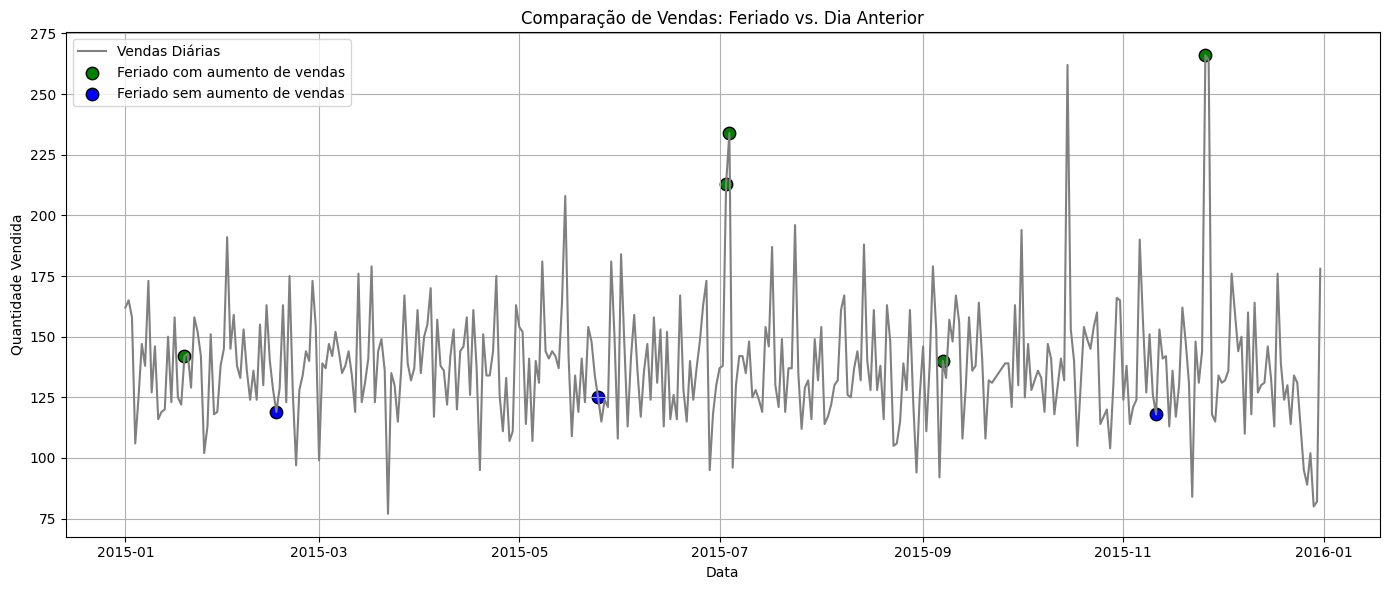

In [26]:
# Agrupar vendas por dia
daily_sales = df_pizza.groupby('order_date')['quantity'].sum().reset_index()

# Criar lista de feriados dos EUA
us_holidays = holidays.US(years=range(daily_sales['order_date'].dt.year.min(), daily_sales['order_date'].dt.year.max() + 1))
holiday_dates = pd.to_datetime(list(us_holidays.keys()))

# Lista para armazenar a comparação feriado vs. dia anterior
feriado_vs_anterior = []

for h_date in holiday_dates:
    day_before = h_date - timedelta(days=1)

    # Verifica se temos dados para ambos os dias
    if h_date in daily_sales['order_date'].values and day_before in daily_sales['order_date'].values:
        venda_feriado = daily_sales.loc[daily_sales['order_date'] == h_date, 'quantity'].values[0]
        venda_dia_anterior = daily_sales.loc[daily_sales['order_date'] == day_before, 'quantity'].values[0]

        aumento = venda_feriado > venda_dia_anterior

        feriado_vs_anterior.append({
            'date': h_date,
            'quantity': venda_feriado,
            'aumento': aumento
        })

# Converter para DataFrame
feriado_df = pd.DataFrame(feriado_vs_anterior)

# Gráfico
plt.figure(figsize=(14, 6))
sns.lineplot(data=daily_sales, x='order_date', y='quantity', label='Vendas Diárias', color='gray')

# Feriados com aumento
aumento_df = feriado_df[feriado_df['aumento']]
queda_df = feriado_df[~feriado_df['aumento']]

plt.scatter(aumento_df['date'], aumento_df['quantity'], color='green', s=80, label='Feriado com aumento de vendas', edgecolor='black')
plt.scatter(queda_df['date'], queda_df['quantity'], color='blue', s=80, label='Feriado sem aumento de vendas', edgecolor='black')

# Ajustes finais
plt.title("Comparação de Vendas: Feriado vs. Dia Anterior")
plt.xlabel("Data")
plt.ylabel("Quantidade Vendida")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Considerando que a pizzaria atua em território americano, é possível verificar o impacto dos feriados nacionais nas vendas de pizza. Alguns feriados não foram considerados, pois a pizzaria estava fechada e não realizou vendas no dia. De 8 feriados, verificou-se que em 5 houve um aumento no número de vendas de pizza. Logo, é importante realizar um controle de estoque para tais datas, além de criar combos de produtos que possam ser consumidos de forma conjunta para aumentar o lucro.

In [27]:
# Total de pizzas vendidas por dia da semana
sales_by_day = df_pizza.groupby('day_of_week')['quantity'].sum().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

# Total de pizzas vendidas por horário do dia
sales_by_hour = df_pizza.groupby('order_hour')['quantity'].sum()

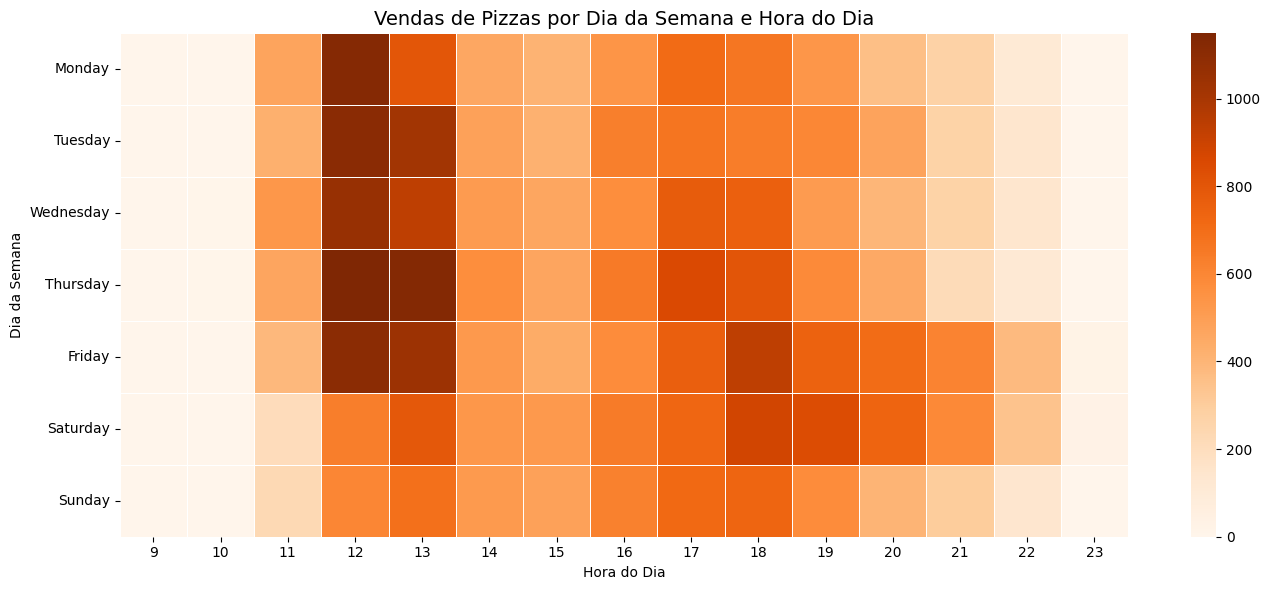

In [28]:
# Agrupa por dia da semana e hora do pedido
heatmap_data = df_pizza.groupby(['day_of_week', 'order_hour'])['quantity'].sum().unstack(fill_value=0)

# Reordena os dias da semana
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(ordered_days)

# Plot do heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap='Oranges', linewidths=0.5, linecolor='white')

plt.title('Vendas de Pizzas por Dia da Semana e Hora do Dia', fontsize=14)
plt.xlabel('Hora do Dia')
plt.ylabel('Dia da Semana')
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


Verifica-se uma predominância das vendas em horários de almoço (12 e 13h) em praticamente todos os dias, com exceção do final de semana, em que o horário de vendas é mais distribuído. Nota-se poucas vendas no início do dia, às 9 e 10h, e no final do dia, às 23h. Pode-se considerar uma mudança no horário de funcionamento da pizzaria de forma que diminua os custos com funcionários sem impactar no número de vendas.

C:\Users\User\AppData\Local\Temp\ipykernel_21084\2327024663.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sales_by_day.index, y=sales_by_day.values, ax=axes[0], palette="Blues")


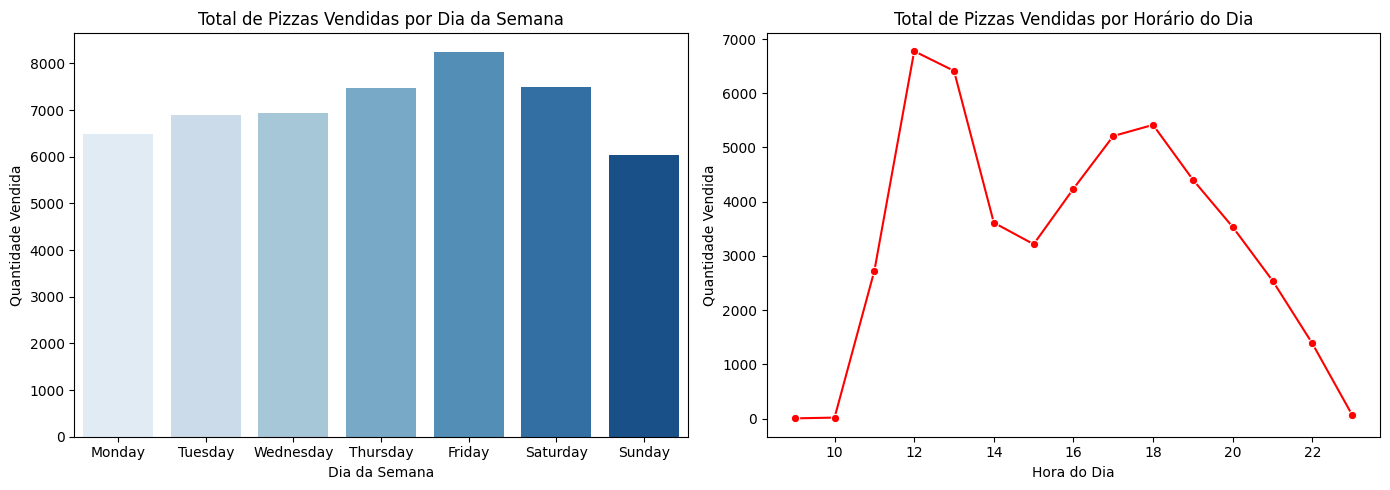

In [29]:
# Criando os gráficos
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 linha, 2 colunas

# Gráfico 1: Vendas por dia da semana
sns.barplot(x=sales_by_day.index, y=sales_by_day.values, ax=axes[0], palette="Blues")
axes[0].set_title("Total de Pizzas Vendidas por Dia da Semana")
axes[0].set_xlabel("Dia da Semana")
axes[0].set_ylabel("Quantidade Vendida")

# Gráfico 2: Vendas por horário do dia
sns.lineplot(x=sales_by_hour.index, y=sales_by_hour.values, marker="o", ax=axes[1], color='red')
axes[1].set_title("Total de Pizzas Vendidas por Horário do Dia")
axes[1].set_xlabel("Hora do Dia")
axes[1].set_ylabel("Quantidade Vendida")

plt.tight_layout()
plt.show()

Com isso, identificamos que: 
- O número de pedidos na semana é maior de quinta a sábado, com um pico na sexta-feira, logo é necessário um estoque maior para tais dias;
- Novamente, nota-se o número baixo de vendas das 9 até às 10h e às 23h, podendo ser possível realizar turnos de trabalho menores.

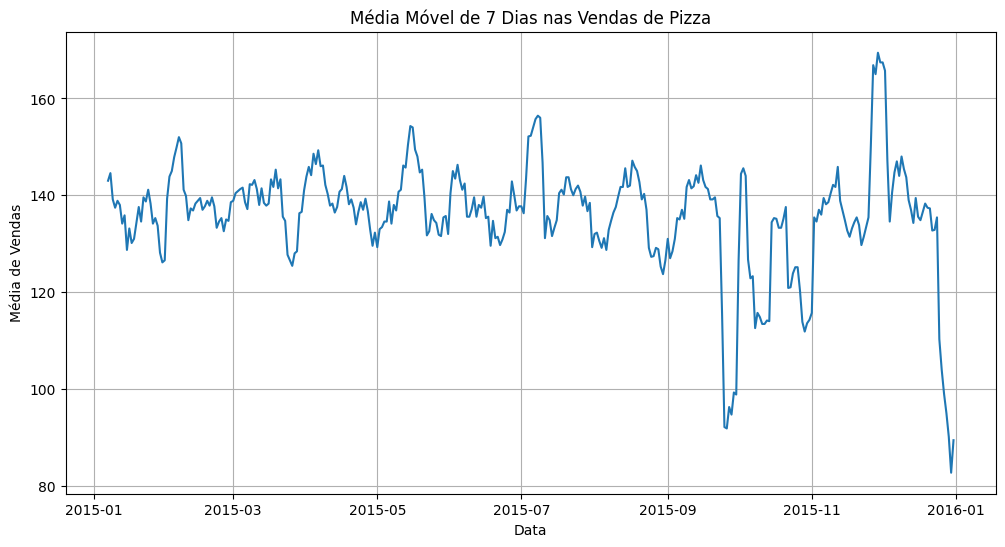

In [30]:
df_pizza = df_pizza.sort_values('order_date')
rolling_sales = df_pizza.set_index('order_date').resample('D')['quantity'].sum().rolling(7).mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=rolling_sales, x='order_date', y='quantity')
plt.title("Média Móvel de 7 Dias nas Vendas de Pizza")
plt.ylabel("Média de Vendas")
plt.xlabel("Data")
plt.grid()
plt.show()

A partir do gráfico de médias móveis, identificamos uma queda no número de vendas em outubro e dezembro. Em outubro, há uma mudança de estação, marcando o início de outono, e mudanças bruscas de temperatura podem impactar a frequência de pedidos, principalmente se as pessoas estiverem se ajustando à nova estação. Caso isso seja algo recorrente, vale a pena realizar uma diminuição do estoque em antecipação. <br>

Em dezembro, a queda dos números pode estar relacionada com os dias que a pizzaria esteve fechada, como no feriado de natal, que pode ter feito com que as pessoas procurassem concorrentes no mesmo período. Para minimizar esse efeito, pode-se procurar formas de abrir a pizzaria em horários reduzidos nessas datas.

## Clusterização de Pedidos

In [31]:
# Agregar as vendas por pedido
order_data = df_pizza.groupby('order_id').agg(
    total_sales=('total_price', 'sum'),
    item_count=('pizza_name', 'count'),
    average_order_value=('total_price', 'mean')
).reset_index()

# Encontrar a categoria de pizza mais comum por pedido
order_data['preferred_category'] = df_pizza.groupby('order_id')['pizza_category'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown')

# Padronizar os dados
features = ['total_sales', 'item_count', 'average_order_value']
scaler = StandardScaler()
order_data_scaled = scaler.fit_transform(order_data[features])

# Aplicar K-Means
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
order_data['cluster'] = kmeans.fit_predict(order_data_scaled)

# Transformar os centróides de volta à escala original
centroids_original_scale = scaler.inverse_transform(kmeans.cluster_centers_)
centroids_df = pd.DataFrame(centroids_original_scale, columns=features)

# Exibir os centróides dos clusters
centroids_df = centroids_df.round(2)
centroids_df

,total_sales,item_count,average_order_value
0,45.71,2.53,18.87
1,23.63,1.63,14.52
2,182.71,10.22,17.89


In [32]:
# Verificar a quantidade de pedidos em cada cluster
order_data['cluster'].value_counts(normalize=True)

cluster
0    0.488431
1    0.487119
2    0.024450
Name: proportion, dtype: float64

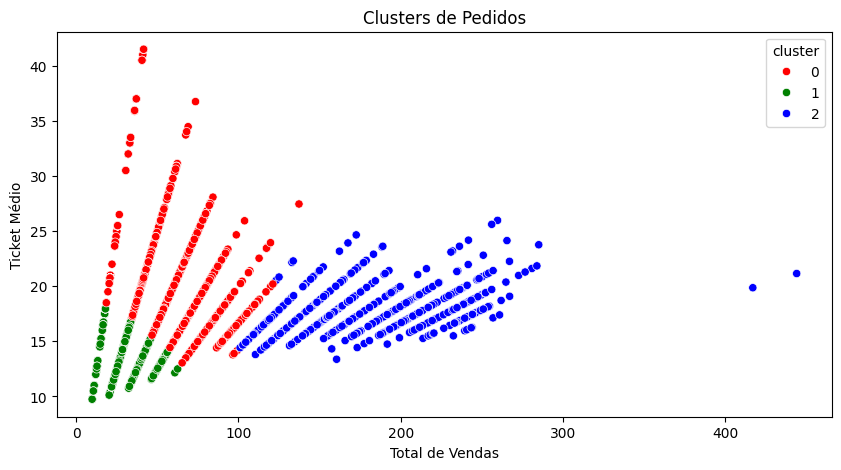

In [33]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=order_data, x='total_sales', y='average_order_value', hue='cluster', palette={0: 'red', 1: 'green', 2: 'blue'})
plt.title('Clusters de Pedidos')
plt.xlabel('Total de Vendas')
plt.ylabel('Ticket Médio')
plt.show()

## Exportar base para dashboard

In [34]:
df_pizza.to_csv("C:\\Users\\User\\Downloads\\Análise Pizzaria\\pizza_db.csv", index=False, sep=",")

Link do Dashboard: https://lookerstudio.google.com/reporting/50d1e569-33c6-4553-bd14-c99fc8446872

## Conclusões

Durante a análise dos dados de vendas da pizzaria, foram identificados padrões de consumo, sazonalidade e oportunidades claras de otimização no cardápio e nas estratégias de vendas. Abaixo, seguem os principais insights:
1. Três Perfis Claros de Clientes
- Segmentamos os pedidos em 3 grupos principais:
  - Pedidos Regulares (Cluster 0): Ticket médio, 2 a 3 pizzas – clientes fiéis, ideal para ofertas de fidelidade e combos.
  - Pedidos Individuais (Cluster 1): Ticket baixo, 1 pizza por pedido – boa oportunidade para menus executivos ou promoções durante a semana.
  - Pedidos para Grupos (Cluster 2): Ticket alto, muitas pizzas – geralmente feitos em datas específicas, ótima chance para campanhas voltadas a eventos e grandes pedidos.
2. Quedas nas Vendas em Períodos Estratégicos
- Notamos quedas acentuadas em outubro e no final de dezembro, períodos em que é possível criar ações específicas para recuperar o volume, como:
  - Combos temáticos para o Halloween
  - Ofertas de fim de ano para festas e confraternizações

3. Diferenças de Rentabilidade entre as Pizzas
- Ao calcular o custo real de cada pizza (considerando ingredientes, tamanho e massa), observamos que:
  - Algumas pizzas têm preço elevado, mas baixa margem
  - Outras, com ingredientes simples, são muito rentáveis
  - Recomendação: Ajustar o cardápio para valorizar as pizzas mais lucrativas e reavaliar preços das menos rentáveis.

Oportunidades de Ação:
- Criar combos baseados nos perfis de clientes identificados
- Reforçar campanhas nos períodos de queda de vendas
- Ajustar preços e promoções com base na margem de lucro real
- Usar dados para decisões contínuas, mantendo o acompanhamento dos resultados



Link Apresentação Slide: https://docs.google.com/presentation/d/1ci7R4GA8uLJA5myfNa4QQhOaE07-sVVu8b5q8IUytT4/edit?usp=sharing